Pipeline de Prédiction des Chèques 2025 - Version GridSearchCV
[20:18:55] Démarrage de la pipeline complète
[20:18:55] Chargement et exploration des données
[20:18:56] Données chargées: 155,210 lignes × 19 colonnes
[20:18:56] Analyse complète de qualité des données
[20:19:09] Préprocessing des données
[20:19:09]    Valeurs manquantes traitées
[20:19:17]    Transformations appliquées
[20:19:18]    Outliers corrigés: 21 colonnes
[20:19:18]    Feature engineering terminé
[20:19:28] Définition des features et targets
[20:19:28]    Features entraînement: 20
[20:19:28]    Features prédiction: 18
[20:19:28]    Targets validation: 2
[20:19:28] Entraînement et validation des modèles
[20:19:28]    Entraînement pour nb_cheques_2024
[20:19:29]    TimeSeriesSplit utilisé pour données temporelles
[20:19:29]       Entraînement PoissonRegressor avec GridSearchCV
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[20:19:52]          Train R²=0.988 | CV R²=0.989
[20:19:52]          Test R²=0.99

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



SystemExit: 1

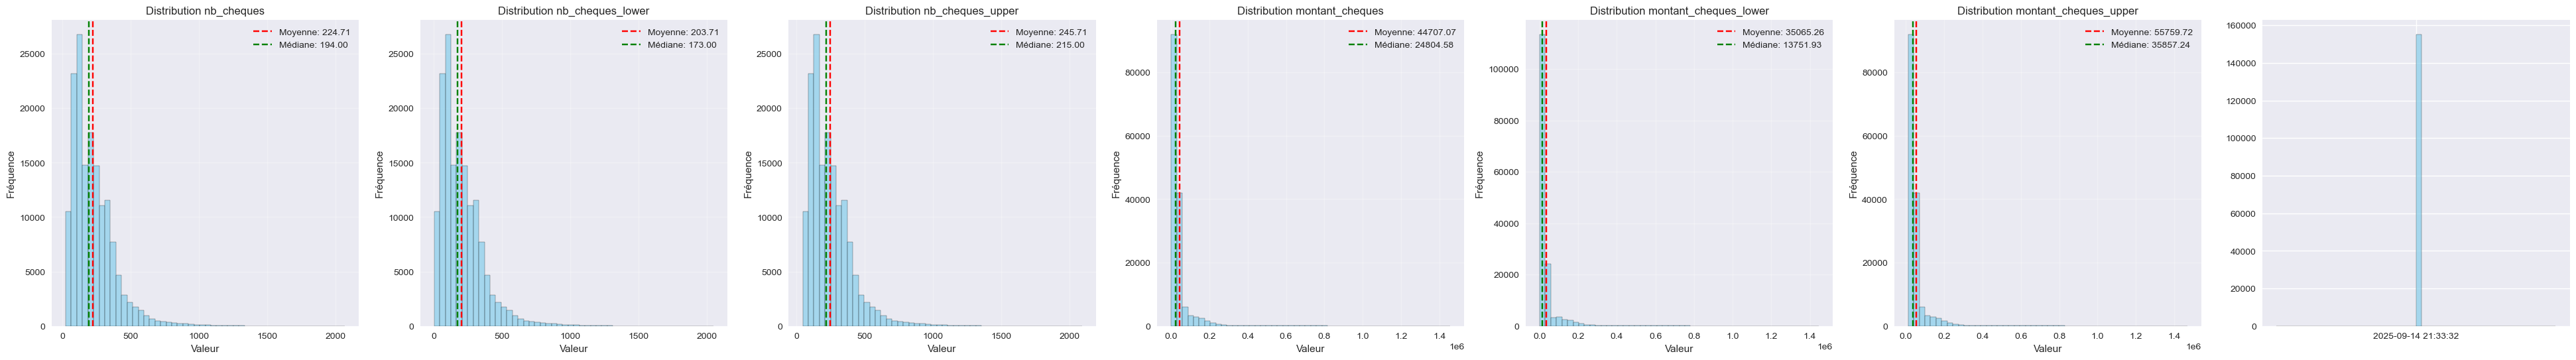

In [19]:
import os
import sys
from pathlib import Path
from datetime import datetime
import warnings
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from typing import Dict, List, Tuple, Optional

from sklearn.model_selection import (
    train_test_split, GridSearchCV, KFold, GroupKFold, cross_val_score,
    TimeSeriesSplit
)
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error, 
    mean_absolute_percentage_error, explained_variance_score
)
from sklearn.feature_selection import VarianceThreshold

# Modèles ML
from sklearn.linear_model import PoissonRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')

# Custom Transformers for feature names propagation
class LogTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__(np.log1p, validate=False)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

class IdentityTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__(func=None, validate=False)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# =========================
#   CONFIGURATION
# =========================
class Config:
    DATA_PATH = r"C:\Users\MSI\Desktop\Attijari_bank\stage\features_cheques_utilisateurs.csv"
    OUT_DIR = r"C:\Users\MSI\Desktop\Attijari_bank\stage\outputs_pipeline"
    
    SKEW_THRESHOLD = 1.0
    IQR_FACTOR = 1.5
    Z_THRESHOLD = 3.0
    RETAIN_THRESHOLD = 0.70
    
    N_JOBS = -1
    RANDOM_STATE = 42
    OVERFIT_THRESHOLD = 0.15
    CV_FOLDS = 5
    VALIDATION_SIZE = 0.25
    
    EXCLUDED_COLUMNS = [
        "id_client", "tranche_plafond", "tranche_anciennete",
        "nb_cheques_2024", "montant_cheques_2024"
    ]

# =========================
#   UTILITAIRES
# =========================
class DataQualityAnalyzer:
    @staticmethod
    def detect_encoding_and_separator(file_path: str) -> Tuple[str, str]:
        encodings = ["utf-8-sig", "utf-8", "latin-1", "cp1252", "iso-8859-1"]
        
        for encoding in encodings:
            try:
                with open(file_path, "r", encoding=encoding, errors="ignore") as f:
                    sample = f.read(2048)
                    separator = csv.Sniffer().sniff(sample).delimiter
                    return encoding, separator
            except Exception:
                continue
        return "utf-8", ";"
    
    @staticmethod
    def comprehensive_stats(series: pd.Series) -> Dict:
        clean_series = pd.to_numeric(series, errors="coerce").dropna()
        
        if len(clean_series) < 3:
            return {"error": "Insufficient data"}
        
        stats_dict = {
            "count": len(clean_series),
            "mean": clean_series.mean(),
            "median": clean_series.median(),
            "std": clean_series.std(),
            "min": clean_series.min(),
            "max": clean_series.max(),
            "q25": clean_series.quantile(0.25),
            "q75": clean_series.quantile(0.75),
            "iqr": clean_series.quantile(0.75) - clean_series.quantile(0.25),
            "skewness": stats.skew(clean_series),
            "kurtosis": stats.kurtosis(clean_series),
            "cv": clean_series.std() / clean_series.mean() if clean_series.mean() != 0 else np.inf
        }
        
        try:
            if len(clean_series) >= 8:
                shapiro_stat, shapiro_p = stats.shapiro(clean_series[:5000])
                stats_dict["shapiro_p"] = shapiro_p
                stats_dict["is_normal_shapiro"] = shapiro_p > 0.05
        except:
            stats_dict["shapiro_p"] = None
            stats_dict["is_normal_shapiro"] = None
        
        return stats_dict
    
    @staticmethod
    def detect_outliers_multiple_methods(series: pd.Series) -> Dict:
        clean_series = pd.to_numeric(series, errors="coerce").fillna(0)
        
        outliers_info = {
            "iqr_outliers": [],
            "zscore_outliers": [],
            "modified_zscore_outliers": [],
            "isolation_forest_outliers": []
        }
        
        q25, q75 = clean_series.quantile([0.25, 0.75])
        iqr = q75 - q25
        if iqr > 0:
            lower_bound = q25 - Config.IQR_FACTOR * iqr
            upper_bound = q75 + Config.IQR_FACTOR * iqr
            outliers_info["iqr_outliers"] = clean_series[(clean_series < lower_bound) | (clean_series > upper_bound)].index.tolist()
            outliers_info["iqr_bounds"] = (lower_bound, upper_bound)
        
        if clean_series.std() > 0:
            z_scores = np.abs(stats.zscore(clean_series))
            outliers_info["zscore_outliers"] = clean_series[z_scores > Config.Z_THRESHOLD].index.tolist()
        
        median = clean_series.median()
        mad = np.median(np.abs(clean_series - median))
        if mad > 0:
            modified_z_scores = 0.6745 * (clean_series - median) / mad
            outliers_info["modified_zscore_outliers"] = clean_series[np.abs(modified_z_scores) > 3.5].index.tolist()
        
        return outliers_info

class DataPreprocessor:
    def __init__(self):
        self.transformations_applied = []
        self.outlier_corrections = {}
    
    def handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        df_processed = df.copy()
        missing_report = {}
        
        for col in df_processed.columns:
            if col in Config.EXCLUDED_COLUMNS:
                continue
                
            missing_pct = df_processed[col].isnull().mean() * 100
            missing_report[col] = missing_pct
            
            if missing_pct > 0:
                if pd.api.types.is_numeric_dtype(df_processed[col]):
                    clean_values = pd.to_numeric(df_processed[col], errors="coerce")
                    if len(clean_values.dropna()) > 0:
                        _, p_value = stats.normaltest(clean_values.dropna())
                        fill_value = clean_values.median() if p_value < 0.05 else clean_values.mean()
                        df_processed[col] = df_processed[col].fillna(fill_value)
                else:
                    mode_value = df_processed[col].mode().iloc[0] if len(df_processed[col].mode()) > 0 else "Unknown"
                    df_processed[col] = df_processed[col].fillna(mode_value)
        
        self.transformations_applied.append(f"Missing values handled: {missing_report}")
        return df_processed
    
    def apply_transformations(self, df: pd.DataFrame) -> pd.DataFrame:
        df_transformed = df.copy()
        transformations_log = {}
        
        numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col not in Config.EXCLUDED_COLUMNS]
        
        for col in numeric_cols:
            series = df_transformed[col]
            stats_info = DataQualityAnalyzer.comprehensive_stats(series)
            
            if stats_info.get("skewness", 0) and abs(stats_info["skewness"]) > Config.SKEW_THRESHOLD:
                if series.min() >= 0:
                    transformed = np.log1p(series)
                    new_skew = stats.skew(transformed.dropna())
                    
                    if abs(new_skew) < abs(stats_info["skewness"]):
                        df_transformed[f"{col}_log"] = transformed
                        transformations_log[col] = f"Log transform applied (skew: {stats_info['skewness']:.3f} -> {new_skew:.3f})"
                
                try:
                    if series.min() > 0:
                        from scipy.stats import boxcox
                        transformed, lambda_param = boxcox(series)
                        new_skew = stats.skew(transformed)
                        
                        if abs(new_skew) < abs(stats_info["skewness"]) * 0.7:
                            df_transformed[f"{col}_boxcox"] = transformed
                            transformations_log[col] += f" | BoxCox applied (λ={lambda_param:.3f})"
                except:
                    pass
        
        self.transformations_applied.append(f"Transformations: {transformations_log}")
        return df_transformed
    
    def correct_outliers(self, df: pd.DataFrame, method: str = "clip") -> pd.DataFrame:
        df_corrected = df.copy()
        
        numeric_cols = df_corrected.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col not in Config.EXCLUDED_COLUMNS]
        
        for col in numeric_cols:
            outliers_info = DataQualityAnalyzer.detect_outliers_multiple_methods(df_corrected[col])
            
            if "nb_cheques" in col:
                q99 = df_corrected[col].quantile(0.99)
                original_values = df_corrected[col].copy()
                df_corrected[col] = df_corrected[col].clip(upper=q99)
                n_clipped = (original_values != df_corrected[col]).sum()
                if n_clipped > 0:
                    self.outlier_corrections[col] = f"Clipped {n_clipped} values to upper bound {q99:.2f}"
            else:
                if method == "clip" and "iqr_bounds" in outliers_info:
                    lower, upper = outliers_info["iqr_bounds"]
                    original_values = df_corrected[col].copy()
                    df_corrected[col] = df_corrected[col].clip(lower=lower, upper=upper)
                    n_clipped = (original_values != df_corrected[col]).sum()
                    if n_clipped > 0:
                        self.outlier_corrections[col] = f"Clipped {n_clipped} values to [{lower:.2f}, {upper:.2f}]"
                elif method == "winsorize":
                    lower_percentile = df_corrected[col].quantile(0.05)
                    upper_percentile = df_corrected[col].quantile(0.95)
                    df_corrected[col] = df_corrected[col].clip(lower=lower_percentile, upper=upper_percentile)
        
        return df_corrected

# =========================
#   PIPELINE PRINCIPALE
# =========================
class AdvancedChequePredictionPipeline:
    def __init__(self, data_path: str, output_dir: str):
        self.data_path = Path(data_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        self.df_raw = None
        self.df_processed = None
        
        self.features_train = []
        self.features_predict = []
        self.targets_2024 = []
        
        self.trained_models = {}
        self.validation_results = {}
        self.predictions_2025 = {}
        
        self.preprocessor = DataPreprocessor()
        
        self.execution_log = []
        self.quality_report = {}
    
    def log_step(self, message: str):
        timestamp = datetime.now().strftime("%H:%M:%S")
        log_message = f"[{timestamp}] {message}"
        print(log_message)
        self.execution_log.append(log_message)
    
    def load_and_explore_data(self) -> pd.DataFrame:
        self.log_step("Chargement et exploration des données")
        
        encoding, separator = DataQualityAnalyzer.detect_encoding_and_separator(str(self.data_path))
        
        try:
            self.df_raw = pd.read_csv(
                self.data_path, 
                sep=separator, 
                encoding=encoding,
                dtype={"id_client": str}
            )
            self.log_step(f"Données chargées: {len(self.df_raw):,} lignes × {len(self.df_raw.columns)} colonnes")
            
            # Vérification des colonnes historiques
            required_cols = ["nb_cheques_2022", "nb_cheques_2023", "montant_cheques_2022", "montant_cheques_2023"]
            missing_cols = [col for col in required_cols if col not in self.df_raw.columns]
            if missing_cols:
                self.log_step(f"Avertissement: Colonnes manquantes: {missing_cols}")
            
        except Exception as e:
            self.log_step(f"Erreur chargement: {e}")
            raise
        
        exploration_report = {
            "shape": self.df_raw.shape,
            "columns": list(self.df_raw.columns),
            "dtypes": self.df_raw.dtypes.to_dict(),
            "missing_values": self.df_raw.isnull().sum().to_dict(),
            "unique_clients": self.df_raw["id_client"].nunique() if "id_client" in self.df_raw.columns else None,
            "years_available": sorted(self.df_raw.select_dtypes(include=[np.number]).columns)
        }
        
        with open(self.output_dir / "data_exploration.json", "w", encoding="utf-8") as f:
            json.dump(exploration_report, f, indent=2, ensure_ascii=False, default=str)
        
        return self.df_raw
    
    def comprehensive_data_quality_analysis(self):
        self.log_step("Analyse complète de qualité des données")
        
        quality_metrics = {}
        
        for col in self.df_raw.columns:
            if col not in Config.EXCLUDED_COLUMNS:
                try:
                    stats_info = DataQualityAnalyzer.comprehensive_stats(self.df_raw[col])
                    outliers_info = DataQualityAnalyzer.detect_outliers_multiple_methods(self.df_raw[col])
                    
                    quality_metrics[col] = {
                        **stats_info,
                        "outliers_iqr_count": len(outliers_info.get("iqr_outliers", [])),
                        "outliers_zscore_count": len(outliers_info.get("zscore_outliers", [])),
                        "outliers_iqr_pct": len(outliers_info.get("iqr_outliers", [])) / len(self.df_raw) * 100,
                        "outliers_zscore_pct": len(outliers_info.get("zscore_outliers", [])) / len(self.df_raw) * 100,
                    }
                    
                except Exception as e:
                    quality_metrics[col] = {"error": str(e)}
        
        quality_df = pd.DataFrame.from_dict(quality_metrics, orient="index")
        quality_df.to_csv(self.output_dir / "data_quality_report.csv", encoding="utf-8-sig")
        
        self.quality_report = quality_metrics
        
        self._create_distribution_plots()
        
        return quality_metrics
    
    def _create_distribution_plots(self):
        numeric_cols = self.df_raw.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col not in Config.EXCLUDED_COLUMNS]
        
        if len(numeric_cols) == 0:
            return
        
        n_cols = min(4, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
        
        for i, col in enumerate(numeric_cols[:len(axes)]):
            if i >= len(axes):
                break
                
            data = pd.to_numeric(self.df_raw[col], errors="coerce").dropna()
            
            if len(data) > 0:
                axes[i].hist(data, bins=50, alpha=0.7, density=True, color='skyblue')
                
                try:
                    from scipy.stats import gaussian_kde
                    if len(data) > 1:
                        kde = gaussian_kde(data)
                        x_range = np.linspace(data.min(), data.max(), 100)
                        axes[i].plot(x_range, kde(x_range), 'r-', linewidth=2, label='Densité')
                except:
                    pass
                
                axes[i].set_title(f'{col}\nSkew: {stats.skew(data):.2f}')
                axes[i].set_ylabel('Densité')
                axes[i].grid(True, alpha=0.3)
        
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / "distributions_before_cleaning.png", dpi=150, bbox_inches='tight')
        plt.close()
    
    def preprocess_data(self):
        self.log_step("Préprocessing des données")
        
        df_work = self.df_raw.copy()
        
        df_work = self.preprocessor.handle_missing_values(df_work)
        self.log_step(f"   Valeurs manquantes traitées")
        
        df_work = self.preprocessor.apply_transformations(df_work)
        self.log_step(f"   Transformations appliquées")
        
        df_work = self.preprocessor.correct_outliers(df_work, method="clip")
        self.log_step(f"   Outliers corrigés: {len(self.preprocessor.outlier_corrections)} colonnes")
        
        df_work = self._engineer_features(df_work)
        self.log_step(f"   Feature engineering terminé")
        
        self.df_processed = df_work
        
        self.df_processed.to_csv(
            self.output_dir / "data_processed.csv", 
            index=False, 
            encoding="utf-8-sig"
        )
        
        return self.df_processed
    
    def _engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df_eng = df.copy()
        
        year_pairs = [(2022, 2023), (2023, 2024)]
        for start_year, end_year in year_pairs:
            nb_start = f"nb_cheques_{start_year}"
            nb_end = f"nb_cheques_{end_year}"
            montant_start = f"montant_cheques_{start_year}"
            montant_end = f"montant_cheques_{end_year}"
            
            if nb_start in df_eng.columns and nb_end in df_eng.columns:
                df_eng[f"trend_nb_{start_year}_{end_year}"] = (
                    (df_eng[nb_end] - df_eng[nb_start]) / 
                    np.maximum(df_eng[nb_start], 1)
                )
            
            if montant_start in df_eng.columns and montant_end in df_eng.columns:
                df_eng[f"trend_montant_{start_year}_{end_year}"] = (
                    (df_eng[montant_end] - df_eng[montant_start]) / 
                    np.maximum(df_eng[montant_start], 1)
                )
        
        # Calculer montant_moyen pour 2023 et 2024 si possible
        if "nb_cheques_2023" in df_eng.columns and "montant_cheques_2023" in df_eng.columns:
            df_eng["montant_moyen_par_cheque_2023"] = (
                df_eng["montant_cheques_2023"] / np.maximum(df_eng["nb_cheques_2023"], 1)
            )
        
        if "nb_cheques_2024" in df_eng.columns and "montant_cheques_2024" in df_eng.columns:
            df_eng["montant_moyen_par_cheque_2024"] = (
                df_eng["montant_cheques_2024"] / np.maximum(df_eng["nb_cheques_2024"], 1)
            )
        
        cheque_cols = [col for col in df_eng.columns if col.startswith("nb_cheques_") and col[-4:].isdigit()]
        if len(cheque_cols) >= 2:
            cheque_values = df_eng[cheque_cols].values
            df_eng["volatility_nb_cheques"] = np.std(cheque_values, axis=1)
            df_eng["mean_nb_cheques"] = np.mean(cheque_values, axis=1)
            df_eng["cv_nb_cheques"] = df_eng["volatility_nb_cheques"] / np.maximum(df_eng["mean_nb_cheques"], 1)
        
        return df_eng
    
    def define_features_and_targets(self):
        self.log_step("Définition des features et targets")
        
        base_features = []
        
        for year in [2022, 2023]:
            for metric in ["nb_cheques", "montant_cheques"]:
                col = f"{metric}_{year}"
                if col in self.df_processed.columns:
                    base_features.append(col)
        
        trend_features = [col for col in self.df_processed.columns if col.startswith("trend_") and "2022_2023" in col]
        base_features.extend(trend_features)
        
        additional_features = [
            "salaire", "plafond_cheque", "montant_total_ops", "ratio_cheques_vs_total",
            "anciennete_compte", "nb_cheques_annuel_moyen", "montant_cheques_annuel_moyen",
            "volatility_nb_cheques", "mean_nb_cheques", "cv_nb_cheques",
            "montant_moyen_par_cheque_2023"
        ]
        
        for feature in additional_features:
            if feature in self.df_processed.columns and feature not in Config.EXCLUDED_COLUMNS:
                base_features.append(feature)
        
        categorical_features = ["type_client", "emploi", "tendance_evolution"]
        for feature in categorical_features:
            if feature in self.df_processed.columns:
                base_features.append(feature)
        
        self.features_train = base_features
        
        self.features_predict = []
        for feature in base_features:
            if "_2022" in feature:
                new_feature = feature.replace("_2022", "_2023")
                if new_feature in self.df_processed.columns:
                    self.features_predict.append(new_feature)
            elif "_2023" in feature and "_2022_2023" not in feature:
                new_feature = feature.replace("_2023", "_2024")
                if new_feature in self.df_processed.columns:
                    self.features_predict.append(new_feature)
            elif "trend_" in feature and "_2022_2023" in feature:
                new_feature = feature.replace("_2022_2023", "_2023_2024")
                if new_feature in self.df_processed.columns:
                    self.features_predict.append(new_feature)
            else:
                if feature in self.df_processed.columns:
                    self.features_predict.append(feature)
        
        self.targets_2024 = [col for col in ["nb_cheques_2024", "montant_cheques_2024"] if col in self.df_processed.columns]
        
        self.log_step(f"   Features entraînement: {len(self.features_train)}")
        self.log_step(f"   Features prédiction: {len(self.features_predict)}")
        self.log_step(f"   Targets validation: {len(self.targets_2024)}")
    
    def create_model_suite(self, target_type: str) -> Dict:
        if target_type == "count":
            models = {
                "PoissonRegressor": (
                    PoissonRegressor(max_iter=1000),
                    {"regressor__alpha": [0.1, 1.0, 10.0, 100.0, 1000.0]}
                ),
                "Ridge": (
                    Ridge(random_state=Config.RANDOM_STATE),
                    {"regressor__alpha": [10.0, 100.0, 1000.0, 10000.0]}
                ),
                "RandomForest": (
                    RandomForestRegressor(
                        n_estimators=100, max_depth=8, min_samples_split=5,
                        min_samples_leaf=3, random_state=Config.RANDOM_STATE, n_jobs=Config.N_JOBS
                    ),
                    {"regressor__max_depth": [6, 8, 10], "regressor__n_estimators": [50, 100, 150]}
                ),
                "GradientBoosting": (
                    GradientBoostingRegressor(
                        n_estimators=100, max_depth=3, learning_rate=0.1,
                        random_state=Config.RANDOM_STATE
                    ),
                    {"regressor__learning_rate": [0.05, 0.1], "regressor__max_depth": [3, 4]}
                )
            }
        else:
            models = {
                "Ridge": (
                    Ridge(random_state=Config.RANDOM_STATE),
                    {"regressor__alpha": [10.0, 100.0, 1000.0, 10000.0]}
                ),
                "Lasso": (
                    Lasso(max_iter=2000, random_state=Config.RANDOM_STATE),
                    {"regressor__alpha": [0.1, 1.0, 10.0, 100.0]}
                ),
                "ElasticNet": (
                    ElasticNet(max_iter=2000, random_state=Config.RANDOM_STATE),
                    {"regressor__alpha": [0.1, 1.0, 10.0], "regressor__l1_ratio": [0.3, 0.5, 0.7]}
                ),
                "RandomForest": (
                    RandomForestRegressor(
                        n_estimators=100, max_depth=10, min_samples_split=5,
                        min_samples_leaf=3, random_state=Config.RANDOM_STATE, n_jobs=Config.N_JOBS
                    ),
                    {"regressor__max_depth": [8, 10, 12], "regressor__n_estimators": [50, 100, 150]}
                ),
                "GradientBoosting": (
                    GradientBoostingRegressor(
                        n_estimators=100, max_depth=4, learning_rate=0.1,
                        random_state=Config.RANDOM_STATE
                    ),
                    {"regressor__learning_rate": [0.05, 0.1], "regressor__max_depth": [3, 4, 5]}
                )
            }
        
        return models
    
    def create_preprocessing_pipeline(self, features: List[str], target_type: str = "amount") -> Pipeline:
        numeric_features = []
        categorical_features = []
        
        for feature in features:
            if feature in self.df_processed.columns:
                if pd.api.types.is_numeric_dtype(self.df_processed[feature]):
                    numeric_features.append(feature)
                else:
                    categorical_features.append(feature)
        
        scaler = self._choose_optimal_scaler(numeric_features)
        
        numeric_pipeline = Pipeline([
            ("log_transform", LogTransformer()) if target_type == "count" else ("identity", IdentityTransformer()),
            ("scaler", scaler),
            ("variance_threshold", VarianceThreshold(threshold=0.01)),
        ])
        
        transformers = []
        if numeric_features:
            transformers.append(("num", numeric_pipeline, numeric_features))
        if categorical_features:
            transformers.append((
                "cat", 
                OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
                categorical_features
            ))
        
        preprocessor = ColumnTransformer(transformers, remainder="drop")
        return preprocessor
    
    def _choose_optimal_scaler(self, numeric_features: List[str]) -> object:
        if not numeric_features:
            return StandardScaler()
        
        skewness_values = []
        for feature in numeric_features:
            if feature in self.df_processed.columns:
                data = pd.to_numeric(self.df_processed[feature], errors="coerce").dropna()
                if len(data) > 3:
                    skewness_values.append(abs(stats.skew(data)))
        
        high_skew_ratio = sum(1 for s in skewness_values if s > Config.SKEW_THRESHOLD) / len(skewness_values)
        
        return RobustScaler() if high_skew_ratio > 0.3 else StandardScaler()
    
    def setup_cross_validation(self, X: pd.DataFrame) -> Tuple[object, Optional[pd.Series]]:
        if "id_client" in self.df_processed.columns:
            client_ids = self.df_processed.loc[X.index, "id_client"]
            if client_ids.duplicated().any():
                self.log_step("   GroupKFold utilisé (clients dupliqués détectés")
                return GroupKFold(n_splits=Config.CV_FOLDS), client_ids
        
        self.log_step("   TimeSeriesSplit utilisé pour données temporelles")
        return TimeSeriesSplit(n_splits=Config.CV_FOLDS), None
    
    def train_and_validate_models(self):
        self.log_step("Entraînement et validation des modèles")
        
        X_train = self.df_processed[self.features_train].copy()
        
        for target_col in self.targets_2024:
            self.log_step(f"   Entraînement pour {target_col}")
            
            y_train = pd.to_numeric(self.df_processed[target_col], errors="coerce").fillna(0)
            
            target_type = "count" if "nb_" in target_col else "amount"
            models_suite = self.create_model_suite(target_type)
            
            preprocessor = self.create_preprocessing_pipeline(self.features_train, target_type=target_type)
            
            cv_splitter, groups = self.setup_cross_validation(X_train)
            
            indices = X_train.index
            train_idx, test_idx = train_test_split(
                indices, test_size=Config.VALIDATION_SIZE, 
                random_state=Config.RANDOM_STATE, stratify=None
            )
            
            X_train_fold = X_train.loc[train_idx]
            X_test_fold = X_train.loc[test_idx]
            y_train_fold = y_train.loc[train_idx]
            y_test_fold = y_train.loc[test_idx]
            
            model_results = {}
            
            for model_name, (base_model, param_grid) in models_suite.items():
                self.log_step(f"      Entraînement {model_name} avec GridSearchCV")
                
                try:
                    pipeline = Pipeline([
                        ("preprocessor", preprocessor),
                        ("regressor", base_model)
                    ])
                    
                    if param_grid:
                        search = GridSearchCV(
                            pipeline, param_grid, 
                            cv=cv_splitter, scoring='r2',
                            n_jobs=Config.N_JOBS, verbose=1,
                            return_train_score=True
                        )
                        
                        if groups is not None:
                            search.fit(X_train_fold, y_train_fold, groups=groups.loc[train_idx])
                        else:
                            search.fit(X_train_fold, y_train_fold)
                        
                        best_model = search.best_estimator_
                        best_params = search.best_params_
                        cv_score = search.best_score_
                        
                        # Vérification de l'overfitting par comparaison train/test
                        train_scores = search.cv_results_['mean_train_score']
                        test_scores = search.cv_results_['mean_test_score']
                        best_idx = search.best_index_
                        train_r2 = train_scores[best_idx]
                        self.log_step(f"         Train R²={train_r2:.3f} | CV R²={cv_score:.3f}")
                    else:
                        pipeline.fit(X_train_fold, y_train_fold)
                        best_model = pipeline
                        best_params = {}
                        
                        if groups is not None:
                            cv_scores = cross_val_score(
                                pipeline, X_train_fold, y_train_fold, 
                                cv=cv_splitter, scoring='r2',
                                groups=groups.loc[train_idx]
                            )
                        else:
                            cv_scores = cross_val_score(
                                pipeline, X_train_fold, y_train_fold,
                                cv=cv_splitter, scoring='r2'
                            )
                        cv_score = cv_scores.mean()
                        train_r2 = r2_score(y_train_fold, pipeline.predict(X_train_fold))
                        self.log_step(f"         Train R²={train_r2:.3f} | CV R²={cv_score:.3f}")
                    
                    y_pred = best_model.predict(X_test_fold)
                    
                    if target_type == "count":
                        y_pred = np.maximum(y_pred, 0).round().astype(int)
                    else:
                        y_pred = np.maximum(y_pred, 0)
                    
                    r2 = r2_score(y_test_fold, y_pred)
                    rmse = mean_squared_error(y_test_fold, y_pred, squared=False)
                    mae = mean_absolute_error(y_test_fold, y_pred)
                    mape = mape_safe(y_test_fold, y_pred)
                    explained_var = explained_variance_score(y_test_fold, y_pred)
                    
                    overfitting_score = abs(cv_score - r2)
                    
                    if overfitting_score > Config.OVERFIT_THRESHOLD:
                        self.log_step(f"         Avertissement: Overfitting détecté pour {model_name} (score={overfitting_score:.3f})")
                    
                    model_results[model_name] = {
                        "model": best_model,
                        "best_params": best_params,
                        "cv_r2": cv_score,
                        "test_r2": r2,
                        "train_r2": train_r2,
                        "rmse": rmse,
                        "mae": mae,
                        "mape": mape,
                        "explained_variance": explained_var,
                        "overfitting_score": overfitting_score,
                        "predictions": y_pred,
                        "actuals": y_test_fold
                    }
                    
                    self.log_step(f"         Test R²={r2:.3f} | RMSE={rmse:.2f} | Overfit={overfitting_score:.3f}")
                    
                except Exception as e:
                    self.log_step(f"         Erreur avec {model_name}: {str(e)[:100]}")
                    continue
            
            if model_results:
                best_model_name = max(
                    model_results.keys(),
                    key=lambda k: model_results[k]["cv_r2"] - 0.2 * model_results[k]["overfitting_score"]
                )
                
                self.trained_models[target_col] = model_results[best_model_name]
                self.validation_results[target_col] = model_results
                
                self.log_step(f"      Meilleur modèle pour {target_col}: {best_model_name}")
            else:
                self.log_step(f"      Aucun modèle réussi pour {target_col}")
    
    def predict_2025(self):
        self.log_step("Génération des prédictions 2025")
        
        X_predict = self.df_processed[self.features_predict].copy()
        
        # Renommer les colonnes de X_predict pour correspondre aux features d'entraînement
        rename_map = {}
        for feature in self.features_train:
            if "_2022" in feature:
                renamed = feature.replace("_2022", "_2023")
                if renamed in X_predict.columns:
                    rename_map[renamed] = feature
            elif "_2023" in feature and "_2022_2023" not in feature:
                renamed = feature.replace("_2023", "_2024")
                if renamed in X_predict.columns:
                    rename_map[renamed] = feature
            elif "trend_" in feature and "_2022_2023" in feature:
                renamed = feature.replace("_2022_2023", "_2023_2024")
                if renamed in X_predict.columns:
                    rename_map[renamed] = feature
            # Pour montant_moyen_par_cheque_2023, utiliser la version 2024 si disponible
            elif feature == "montant_moyen_par_cheque_2023":
                if "montant_moyen_par_cheque_2024" in X_predict.columns:
                    rename_map["montant_moyen_par_cheque_2024"] = feature
        
        X_predict_renamed = X_predict.rename(columns=rename_map)
        
        # Vérifier si toutes les features d'entraînement sont présentes après renommage
        missing = [f for f in self.features_train if f not in X_predict_renamed.columns]
        if missing:
            self.log_step(f"   Avertissement: Features manquantes pour prédiction: {missing}")
            # Remplir les manquantes avec 0 ou moyenne si nécessaire
            for f in missing:
                X_predict_renamed[f] = 0  # Ou df_processed[f].mean() si approprié
        
        predictions_df = pd.DataFrame(index=X_predict.index)
        
        if "id_client" in self.df_processed.columns:
            predictions_df["id_client"] = self.df_processed["id_client"]
        
        for target_col in self.targets_2024:
            if target_col in self.trained_models:
                model_info = self.trained_models[target_col]
                best_model = model_info["model"]
                
                try:
                    predictions = best_model.predict(X_predict_renamed)
                    
                    if "nb_" in target_col:
                        predictions = np.maximum(predictions, 0).round().astype(int)
                        pred_col = "prediction_nb_cheques_2025"
                    else:
                        predictions = np.maximum(predictions, 0)
                        pred_col = "prediction_montant_cheques_2025"
                    
                    predictions_df[pred_col] = predictions
                    
                    std_error = model_info["rmse"]
                    predictions_df[f"{pred_col}_lower"] = predictions - 1.96 * std_error
                    predictions_df[f"{pred_col}_upper"] = predictions + 1.96 * std_error
                    
                    if "nb_" in target_col:
                        predictions_df[f"{pred_col}_lower"] = np.maximum(predictions_df[f"{pred_col}_lower"], 0).round().astype(int)
                        predictions_df[f"{pred_col}_upper"] = np.maximum(predictions_df[f"{pred_col}_upper"], 0).round().astype(int)
                    else:
                        predictions_df[f"{pred_col}_lower"] = np.maximum(predictions_df[f"{pred_col}_lower"], 0)
                        predictions_df[f"{pred_col}_upper"] = np.maximum(predictions_df[f"{pred_col}_upper"], 0)
                    
                    self.log_step(f"   Prédictions {pred_col}: {predictions.sum():,.0f} (total)")
                    
                except Exception as e:
                    self.log_step(f"   Erreur prédiction {target_col}: {e}")
        
        historical_cols = [
            "nb_cheques_2022", "nb_cheques_2023", "nb_cheques_2024",
            "montant_cheques_2022", "montant_cheques_2023", "montant_cheques_2024"
        ]
        
        for col in historical_cols:
            if col in self.df_processed.columns:
                predictions_df[col] = self.df_processed[col]
        
        if "prediction_nb_cheques_2025" in predictions_df.columns and "nb_cheques_2024" in predictions_df.columns:
            predictions_df["tendance_nb_2024_2025"] = (
                (predictions_df["prediction_nb_cheques_2025"] - predictions_df["nb_cheques_2024"]) /
                np.maximum(predictions_df["nb_cheques_2024"], 1)
            )
        
        if "prediction_montant_cheques_2025" in predictions_df.columns and "montant_cheques_2024" in predictions_df.columns:
            predictions_df["tendance_montant_2024_2025"] = (
                (predictions_df["prediction_montant_cheques_2025"] - predictions_df["montant_cheques_2024"]) /
                np.maximum(predictions_df["montant_cheques_2024"], 1)
            )
        
        predictions_df["prediction_date"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        predictions_df["model_version"] = "v2.0_gridsearch"
        
        predictions_df.to_csv(
            self.output_dir / "predictions_2025_detailed.csv",
            index=False, encoding="utf-8-sig"
        )
        
        compact_cols = ["id_client"] if "id_client" in predictions_df.columns else []
        compact_cols.extend([col for col in predictions_df.columns if col.startswith("prediction_") or col.startswith("tendance_")])
        
        predictions_df[compact_cols].to_csv(
            self.output_dir / "predictions_2025_compact.csv",
            index=False, encoding="utf-8-sig"
        )
        
        self.predictions_2025 = predictions_df
        return predictions_df
    
    def analyze_feature_importance(self):
        self.log_step("Analyse de l'importance des features")
        
        importance_results = {}
        
        for target_col, model_info in self.trained_models.items():
            try:
                model = model_info["model"]
                
                preprocessor = model.named_steps["preprocessor"]
                feature_names = preprocessor.get_feature_names_out()
                
                regressor = model.named_steps["regressor"]
                
                if hasattr(regressor, "feature_importances_"):
                    importance_values = regressor.feature_importances_
                elif hasattr(regressor, "coef_"):
                    importance_values = np.abs(regressor.coef_)
                    if len(importance_values.shape) > 1:
                        importance_values = importance_values[0]
                else:
                    self.log_step(f"   Importance non disponible pour {target_col}")
                    continue
                
                importance_df = pd.DataFrame({
                    "feature": feature_names,
                    "importance": importance_values
                }).sort_values("importance", ascending=False)
                
                importance_df["importance_pct"] = (
                    importance_df["importance"] / importance_df["importance"].sum() * 100
                )
                
                importance_results[target_col] = importance_df
                
                importance_df.to_csv(
                    self.output_dir / f"feature_importance_{target_col}.csv",
                    index=False, encoding="utf-8-sig"
                )
                
                top_10 = importance_df.head(10)
                self.log_step(f"   Top 3 features pour {target_col}:")
                for _, row in top_10.head(3).iterrows():
                    self.log_step(f"      {row['feature']}: {row['importance_pct']:.1f}%")
                
            except Exception as e:
                self.log_step(f"   Erreur analyse importance {target_col}: {e}")
        
        return importance_results
    
    def create_comprehensive_visualizations(self):
        self.log_step("Création des visualisations")
        
        self._create_temporal_evolution_chart()
        self._create_validation_charts()
        self._create_prediction_distribution_charts()
        self._create_feature_importance_charts()
        self._create_model_performance_comparison()
    
    def _create_temporal_evolution_chart(self):
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        years = [2022, 2023, 2024, 2025]
        
        nb_values = []
        for year in [2022, 2023, 2024]:
            col = f"nb_cheques_{year}"
            if col in self.df_processed.columns:
                nb_values.append(self.df_processed[col].sum())
            else:
                nb_values.append(0)
        
        if "prediction_nb_cheques_2025" in self.predictions_2025.columns:
            nb_values.append(self.predictions_2025["prediction_nb_cheques_2025"].sum())
        else:
            nb_values.append(0)
        
        axes[0].plot(years[:3], nb_values[:3], 'bo-', linewidth=3, markersize=8, label='Historique')
        axes[0].plot([2024, 2025], nb_values[2:], 'ro--', linewidth=3, markersize=8, label='Prédiction')
        axes[0].fill_between([2024, 2025], nb_values[2:], alpha=0.3, color='red')
        axes[0].set_title('Évolution du Nombre Total de Chèques', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Nombre de Chèques', fontsize=12)
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        montant_values = []
        for year in [2022, 2023, 2024]:
            col = f"montant_cheques_{year}"
            if col in self.df_processed.columns:
                montant_values.append(self.df_processed[col].sum())
            else:
                montant_values.append(0)
        
        if "prediction_montant_cheques_2025" in self.predictions_2025.columns:
            montant_values.append(self.predictions_2025["prediction_montant_cheques_2025"].sum())
        else:
            montant_values.append(0)
        
        axes[1].plot(years[:3], montant_values[:3], 'go-', linewidth=3, markersize=8, label='Historique')
        axes[1].plot([2024, 2025], montant_values[2:], 'ro--', linewidth=3, markersize=8, label='Prédiction')
        axes[1].fill_between([2024, 2025], montant_values[2:], alpha=0.3, color='red')
        axes[1].set_title('Évolution du Montant Total des Chèques', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Année', fontsize=12)
        axes[1].set_ylabel('Montant (€)', fontsize=12)
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M€'))
        
        plt.tight_layout()
        plt.savefig(self.output_dir / "evolution_temporelle_2022_2025.png", dpi=150, bbox_inches='tight')
        plt.close()
    
    def _create_validation_charts(self):
        n_targets = len(self.trained_models)
        if n_targets == 0:
            return
        
        fig, axes = plt.subplots(1, n_targets, figsize=(7*n_targets, 6))
        if n_targets == 1:
            axes = [axes]
        
        for i, (target_col, model_info) in enumerate(self.trained_models.items()):
            y_actual = model_info["actuals"]
            y_pred = model_info["predictions"]
            
            axes[i].scatter(y_actual, y_pred, alpha=0.6, s=50)
            
            min_val = min(y_actual.min(), y_pred.min())
            max_val = max(y_actual.max(), y_pred.max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction Parfaite')
            
            r2 = model_info["test_r2"]
            rmse = model_info["rmse"]
            
            axes[i].set_title(f'Validation {target_col}\nR² = {r2:.3f} | RMSE = {rmse:.2f}', fontsize=12)
            axes[i].set_xlabel('Valeurs Réelles')
            axes[i].set_ylabel('Valeurs Prédites')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / "validation_performance.png", dpi=150, bbox_inches='tight')
        plt.close()
    
    def _create_prediction_distribution_charts(self):
        pred_cols = [col for col in self.predictions_2025.columns if col.startswith("prediction_")]
        
        if not pred_cols:
            return
        
        fig, axes = plt.subplots(1, len(pred_cols), figsize=(7*len(pred_cols), 6))
        if len(pred_cols) == 1:
            axes = [axes]
        
        for i, col in enumerate(pred_cols):
            data = self.predictions_2025[col].dropna()
            
            axes[i].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            
            mean_val = data.mean()
            median_val = data.median()
            
            axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Moyenne: {mean_val:.2f}')
            axes[i].axvline(median_val, color='green', linestyle='--', label=f'Médiane: {median_val:.2f}')
            
            axes[i].set_title(f'Distribution {col.replace("prediction_", "").replace("_2025", "")}')
            axes[i].set_xlabel('Valeur')
            axes[i].set_ylabel('Fréquence')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / "distribution_predictions_2025.png", dpi=150, bbox_inches='tight')
        plt.close()
    
    def _create_feature_importance_charts(self):
        importance_data = self.analyze_feature_importance()
        
        for target_col, importance_df in importance_data.items():
            top_features = importance_df.head(15)
            
            plt.figure(figsize=(12, 8))
            
            bars = plt.barh(range(len(top_features)), top_features["importance_pct"])
            plt.yticks(range(len(top_features)), top_features["feature"])
            
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
            for bar, color in zip(bars, colors):
                bar.set_color(color)
            
            plt.xlabel('Importance (%)')
            plt.title(f'Importance des Features - {target_col}', fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3)
            
            for i, (_, row) in enumerate(top_features.iterrows()):
                plt.text(row["importance_pct"] + 0.5, i, f'{row["importance_pct"]:.1f}%', 
                        va='center', fontsize=9)
            
            plt.tight_layout()
            plt.savefig(self.output_dir / f"feature_importance_{target_col}.png", dpi=150, bbox_inches='tight')
            plt.close()
    
    def _create_model_performance_comparison(self):
        all_models = []
        
        for target_col, models_dict in self.validation_results.items():
            for model_name, metrics in models_dict.items():
                all_models.append({
                    "target": target_col,
                    "model": model_name,
                    "cv_r2": metrics["cv_r2"],
                    "test_r2": metrics["test_r2"],
                    "train_r2": metrics["train_r2"],
                    "rmse": metrics["rmse"],
                    "overfitting": metrics["overfitting_score"]
                })
        
        if not all_models:
            return
        
        df_models = pd.DataFrame(all_models)
        
        r2_data = []
        rmse_data = []
        train_r2_data = []
        labels = []
        
        for target in df_models["target"].unique():
            target_data = df_models[df_models["target"] == target]
            r2_data.append({
                "label": f"R² Test - {target}",
                "data": target_data["test_r2"].tolist(),
                "backgroundColor": "rgba(54, 162, 235, 0.6)" if target == "nb_cheques_2024" else "rgba(255, 99, 132, 0.6)"
            })
            train_r2_data.append({
                "label": f"R² Train - {target}",
                "data": target_data["train_r2"].tolist(),
                "backgroundColor": "rgba(54, 162, 235, 0.3)" if target == "nb_cheques_2024" else "rgba(255, 99, 132, 0.3)"
            })
            rmse_data.append({
                "label": f"RMSE - {target}",
                "data": target_data["rmse"].tolist(),
                "backgroundColor": "rgba(75, 192, 192, 0.6)" if target == "nb_cheques_2024" else "rgba(153, 102, 255, 0.6)"
            })
            if not labels:
                labels = target_data["model"].tolist()
        
        r2_chart = {
            "type": "bar",
            "data": {
                "labels": labels,
                "datasets": r2_data + train_r2_data
            },
            "options": {
                "indexAxis": "x",
                "scales": {
                    "y": {
                        "beginAtZero": True,
                        "title": {"display": True, "text": "R² Score"}
                    },
                    "x": {
                        "title": {"display": True, "text": "Modèle"}
                    }
                },
                "plugins": {
                    "title": {"display": True, "text": "Comparaison des R² (Train vs Test) par Modèle"},
                    "legend": {"position": "top"}
                }
            }
        }
        
        rmse_chart = {
            "type": "bar",
            "data": {
                "labels": labels,
                "datasets": rmse_data
            },
            "options": {
                "indexAxis": "x",
                "scales": {
                    "y": {
                        "beginAtZero": True,
                        "title": {"display": True, "text": "RMSE"}
                    },
                    "x": {
                        "title": {"display": True, "text": "Modèle"}
                    }
                },
                "plugins": {
                    "title": {"display": True, "text": "Comparaison des RMSE par Modèle"},
                    "legend": {"position": "top"}
                }
            }
        }
        
        with open(self.output_dir / "r2_comparison_chart.json", "w") as f:
            json.dump(r2_chart, f, indent=2)
        with open(self.output_dir / "rmse_comparison_chart.json", "w") as f:
            json.dump(rmse_chart, f, indent=2)
        
        self.log_step("Graphiques de comparaison des performances générés")
    
    def generate_comprehensive_report(self):
        self.log_step("Génération du rapport complet")
        
        report = {
            "metadata": {
                "execution_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "pipeline_version": "v2.0_gridsearch",
                "data_source": str(self.data_path),
                "output_directory": str(self.output_dir)
            },
            "data_quality": {
                "original_rows": len(self.df_raw) if self.df_raw is not None else 0,
                "processed_rows": len(self.df_processed) if self.df_processed is not None else 0,
                "retention_rate": len(self.df_processed) / len(self.df_raw) * 100 if self.df_raw is not None and len(self.df_raw) > 0 else 0,
                "features_train": len(self.features_train),
                "features_predict": len(self.features_predict),
                "outliers_corrected": len(self.preprocessor.outlier_corrections),
                "transformations_applied": len(self.preprocessor.transformations_applied)
            },
            "model_performance": {},
            "predictions_2025": {},
            "recommendations": []
        }
        
        for target_col, model_info in self.trained_models.items():
            report["model_performance"][target_col] = {
                "best_model": type(model_info["model"].named_steps["regressor"]).__name__,
                "cv_r2": float(model_info["cv_r2"]),
                "test_r2": float(model_info["test_r2"]),
                "train_r2": float(model_info["train_r2"]),
                "rmse": float(model_info["rmse"]),
                "mae": float(model_info["mae"]),
                "mape": float(model_info["mape"]),
                "explained_variance": float(model_info["explained_variance"]),
                "overfitting_score": float(model_info["overfitting_score"]),
                "performance_grade": self._calculate_performance_grade(model_info)
            }
        
        if not self.predictions_2025.empty:
            if "prediction_nb_cheques_2025" in self.predictions_2025.columns:
                nb_pred = self.predictions_2025["prediction_nb_cheques_2025"]
                report["predictions_2025"]["nb_cheques"] = {
                    "total_predicted": int(nb_pred.sum()),
                    "mean_per_client": float(nb_pred.mean()),
                    "median_per_client": float(nb_pred.median()),
                    "std_per_client": float(nb_pred.std()),
                    "min_max": [int(nb_pred.min()), int(nb_pred.max())],
                    "percentiles": {
                        "p25": float(nb_pred.quantile(0.25)),
                        "p75": float(nb_pred.quantile(0.75)),
                        "p90": float(nb_pred.quantile(0.90)),
                        "p95": float(nb_pred.quantile(0.95))
                    }
                }
            
            if "prediction_montant_cheques_2025" in self.predictions_2025.columns:
                mt_pred = self.predictions_2025["prediction_montant_cheques_2025"]
                report["predictions_2025"]["montant_cheques"] = {
                    "total_predicted": float(mt_pred.sum()),
                    "mean_per_client": float(mt_pred.mean()),
                    "median_per_client": float(mt_pred.median()),
                    "std_per_client": float(mt_pred.std()),
                    "min_max": [float(mt_pred.min()), float(mt_pred.max())],
                    "percentiles": {
                        "p25": float(mt_pred.quantile(0.25)),
                        "p75": float(mt_pred.quantile(0.75)),
                        "p90": float(mt_pred.quantile(0.90)),
                        "p95": float(mt_pred.quantile(0.95))
                    }
                }
        
        report["recommendations"] = self._generate_recommendations(report)
        
        report["business_insights"] = self._generate_business_insights()
        
        with open(self.output_dir / "comprehensive_report.json", "w", encoding="utf-8") as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        
        self._create_markdown_report(report)
        
        return report
    
    def _calculate_performance_grade(self, model_info: Dict) -> str:
        r2 = model_info["test_r2"]
        overfit = model_info["overfitting_score"]
        
        score = r2 - 0.5 * overfit
        
        if score >= 0.8:
            return "Excellent"
        elif score >= 0.6:
            return "Bon"
        elif score >= 0.4:
            return "Moyen"
        elif score >= 0.2:
            return "Faible"
        else:
            return "Très Faible"
    
    def _generate_recommendations(self, report: Dict) -> List[str]:
        recommendations = []
        
        for target, perf in report["model_performance"].items():
            if perf["test_r2"] < 0.5:
                recommendations.append(
                    f"Performance faible pour {target} (R²={perf['test_r2']:.2f}). "
                    f"Considérer l'ajout de features externes (macro-économiques, saisonnalité)."
                )
            
            if perf["overfitting_score"] > Config.OVERFIT_THRESHOLD:
                recommendations.append(
                    f"Overfitting détecté pour {target} (score={perf['overfitting_score']:.3f}). "
                    f"Augmenter la régularisation ou réduire la complexité du modèle."
                )
        
        retention_rate = report["data_quality"]["retention_rate"]
        if retention_rate < 80:
            recommendations.append(
                f"Taux de rétention des données faible ({retention_rate:.1f}%). "
                f"Améliorer le preprocessing pour préserver plus de données."
            )
        
        if "predictions_2025" in report and "nb_cheques" in report["predictions_2025"]:
            cv_nb = (report["predictions_2025"]["nb_cheques"]["std_per_client"] / 
                    report["predictions_2025"]["nb_cheques"]["mean_per_client"])
            if cv_nb > 1.0:
                recommendations.append(
                    f"Grande variabilité des prédictions (CV={cv_nb:.2f}). "
                    f"Segmenter les clients pour des modèles plus précis."
                )
        
        recommendations.extend([
            "Mettre en place un monitoring en temps réel des performances",
            "Réentraîner les modèles mensuellement avec les nouvelles données",
            "Développer des modèles spécialisés par segment de clientèle",
            "Intégrer des features de saisonnalité et tendances macro-économiques",
            "Considérer des modèles plus avancés (XGBoost, LightGBM)",
            "Déployer un tableau de bord interactif pour le suivi des prédictions"
        ])
        
        return recommendations[:10]
    
    def _generate_business_insights(self) -> Dict:
        insights = {}
        
        if not self.predictions_2025.empty:
            if "tendance_nb_2024_2025" in self.predictions_2025.columns:
                trend_nb = self.predictions_2025["tendance_nb_2024_2025"]
                insights["trend_nb_cheques"] = {
                    "growth_clients_pct": float((trend_nb > 0.05).mean() * 100),
                    "decline_clients_pct": float((trend_nb < -0.05).mean() * 100),
                    "stable_clients_pct": float((abs(trend_nb) <= 0.05).mean() * 100),
                    "average_growth": float(trend_nb.mean()),
                    "median_growth": float(trend_nb.median())
                }
            
            if "tendance_montant_2024_2025" in self.predictions_2025.columns:
                trend_mt = self.predictions_2025["tendance_montant_2024_2025"]
                insights["trend_montant_cheques"] = {
                    "growth_clients_pct": float((trend_mt > 0.05).mean() * 100),
                    "decline_clients_pct": float((trend_mt < -0.05).mean() * 100),
                    "stable_clients_pct": float((abs(trend_mt) <= 0.05).mean() * 100),
                    "average_growth": float(trend_mt.mean()),
                    "median_growth": float(trend_mt.median())
                }
            
            if "prediction_nb_cheques_2025" in self.predictions_2025.columns:
                nb_pred = self.predictions_2025["prediction_nb_cheques_2025"]
                insights["client_segments"] = {
                    "high_volume_pct": float((nb_pred > nb_pred.quantile(0.8)).mean() * 100),
                    "medium_volume_pct": float(((nb_pred >= nb_pred.quantile(0.2)) & 
                                              (nb_pred <= nb_pred.quantile(0.8))).mean() * 100),
                    "low_volume_pct": float((nb_pred < nb_pred.quantile(0.2)).mean() * 100),
                    "high_volume_threshold": float(nb_pred.quantile(0.8)),
                    "low_volume_threshold": float(nb_pred.quantile(0.2))
                }
        
        return insights
    
    def _create_markdown_report(self, report: Dict):
        markdown_content = f"""# Rapport de Prédiction des Chèques 2025

**Date d'exécution :** {report['metadata']['execution_date']}
**Version de la pipeline :** {report['metadata']['pipeline_version']}

## Résumé Exécutif

Ce rapport présente les résultats de la pipeline de prédiction pour les chèques en 2025, basée sur l'analyse des données historiques 2022-2024.

### Prédictions Clés 2025

"""
        
        if "predictions_2025" in report:
            if "nb_cheques" in report["predictions_2025"]:
                nb_total = report["predictions_2025"]["nb_cheques"]["total_predicted"]
                markdown_content += f"- **Nombre total de chèques prévu :** {nb_total:,}\n"
            
            if "montant_cheques" in report["predictions_2025"]:
                mt_total = report["predictions_2025"]["montant_cheques"]["total_predicted"]
                markdown_content += f"- **Montant total prévu :** {mt_total:,.0f} €\n"
        
        markdown_content += f"""

## Qualité des Données

| Métrique | Valeur |
|----------|--------|
| Lignes originales | {report['data_quality']['original_rows']:,} |
| Lignes après nettoyage | {report['data_quality']['processed_rows']:,} |
| Taux de rétention | {report['data_quality']['retention_rate']:.1f}% |
| Features d'entraînement | {report['data_quality']['features_train']} |
| Outliers corrigés | {report['data_quality']['outliers_corrected']} |

## Performance des Modèles

"""
        
        for target, perf in report["model_performance"].items():
            markdown_content += f"""
### {target}

- **Modèle sélectionné :** {perf['best_model']}
- **Performance :** {perf['performance_grade']}
- **R² Test :** {perf['test_r2']:.3f}
- **R² Train :** {perf['train_r2']:.3f}
- **R² CV :** {perf['cv_r2']:.3f}
- **RMSE :** {perf['rmse']:.2f}
- **MAPE :** {perf['mape']:.1f}%
- **Score d'overfitting :** {perf['overfitting_score']:.3f}

"""
        
        markdown_content += f"""
## Insights Business

"""
        
        if "business_insights" in report:
            insights = report["business_insights"]
            
            if "trend_nb_cheques" in insights:
                trend = insights["trend_nb_cheques"]
                markdown_content += f"""
### Tendances Nombre de Chèques
- **Clients en croissance (>5%) :** {trend['growth_clients_pct']:.1f}%
- **Clients en déclin (<-5%) :** {trend['decline_clients_pct']:.1f}%
- **Clients stables :** {trend['stable_clients_pct']:.1f}%
- **Croissance moyenne :** {trend['average_growth']:.1%}

"""
            
            if "client_segments" in insights:
                segments = insights["client_segments"]
                markdown_content += f"""
### Segmentation Clientèle 2025
- **Gros volumes (top 20%) :** {segments['high_volume_pct']:.1f}% des clients
- **Volumes moyens :** {segments['medium_volume_pct']:.1f}% des clients
- **Petits volumes :** {segments['low_volume_pct']:.1f}% des clients

"""
        
        markdown_content += f"""
## Recommandations

"""
        
        for i, rec in enumerate(report["recommendations"], 1):
            markdown_content += f"{i}. {rec}\n"
        
        markdown_content += f"""

## Fichiers de Sortie

- `predictions_2025_detailed.csv` : Prédictions détaillées par client
- `predictions_2025_compact.csv` : Version compacte des prédictions
- `data_quality_report.csv` : Rapport de qualité des données
- `feature_importance_*.csv` : Importance des features par modèle
- Graphiques : `*.png`, `*.json`

## Configuration Technique

- **Méthode de validation :** {Config.CV_FOLDS}-fold cross-validation (TimeSeriesSplit)
- **Seuil d'overfitting :** {Config.OVERFIT_THRESHOLD}
- **Seuil d'asymétrie :** {Config.SKEW_THRESHOLD}
- **Facteur IQR :** {Config.IQR_FACTOR}

---
*Rapport généré automatiquement par la Pipeline de Prédiction v{report['metadata']['pipeline_version']}*
"""
        
        with open(self.output_dir / "rapport_executif.md", "w", encoding="utf-8") as f:
            f.write(markdown_content)
    
    def run_complete_pipeline(self):
        self.log_step("Démarrage de la pipeline complète")
        
        try:
            self.load_and_explore_data()
            self.comprehensive_data_quality_analysis()
            self.preprocess_data()
            self.define_features_and_targets()
            self.train_and_validate_models()
            self.predict_2025()
            self.analyze_feature_importance()
            self.create_comprehensive_visualizations()
            final_report = self.generate_comprehensive_report()
            
            self.log_step("Pipeline terminée avec succès!")
            
            self._print_final_summary(final_report)
            
            return final_report
            
        except Exception as e:
            self.log_step(f"Erreur dans la pipeline: {str(e)}")
            import traceback
            traceback.print_exc()
            raise
    
    def _print_final_summary(self, report: Dict):
        print("\n" + "="*80)
        print("PIPELINE DE PRÉDICTION TERMINÉE")
        print("="*80)
        
        print(f"Données traitées : {report['data_quality']['processed_rows']:,} lignes")
        print(f"Modèles entraînés : {len(report['model_performance'])}")
        
        if "predictions_2025" in report:
            if "nb_cheques" in report["predictions_2025"]:
                total_nb = report["predictions_2025"]["nb_cheques"]["total_predicted"]
                print(f"Chèques prédits 2025 : {total_nb:,}")
            
            if "montant_cheques" in report["predictions_2025"]:
                total_mt = report["predictions_2025"]["montant_cheques"]["total_predicted"]
                print(f"Montant prédit 2025 : {total_mt:,.0f} €")
        
        print(f"\nFichiers générés dans : {self.output_dir}")
        print("Voir 'rapport_executif.md' pour le rapport complet")
        print("="*80)

# =========================
#   FONCTION UTILITAIRE MAPE
# =========================
def mape_safe(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.maximum(np.asarray(y_pred, dtype=float), 0)
    return mean_absolute_percentage_error(np.maximum(np.abs(y_true), 1e-6), y_pred)

# =========================
#   POINT D'ENTRÉE
# =========================
if __name__ == "__main__":
    print("Pipeline de Prédiction des Chèques 2025 - Version GridSearchCV")
    print("=" * 80)
    
    data_path = Config.DATA_PATH
    output_dir = Config.OUT_DIR
    
    if not Path(data_path).exists():
        print(f"Fichier de données introuvable : {data_path}")
        print("Vérifiez le chemin dans Config.DATA_PATH")
        sys.exit(1)
    
    pipeline = AdvancedChequePredictionPipeline(data_path, output_dir)
    
    try:
        final_report = pipeline.run_complete_pipeline()
        
        print(f"\nSuccès ! Consultez les résultats dans :")
        print(f"   {output_dir}")
        print(f"   {output_dir}/rapport_executif.md")
        
    except KeyboardInterrupt:
        print("\nPipeline interrompue par l'utilisateur")
    except Exception as e:
        print(f"\nErreur fatale : {e}")
        print("Consultez les logs pour plus de détails")
        sys.exit(1)